# Analyzing customer spending in a Wholesale Market

Goal: Use DBSCAN clustering techniques to group customers according to their grocery spending habits

## DBSCAN Project  

### The Data

Source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Margarida G. M. S. Cardoso, margarida.cardoso '@' iscte.pt, ISCTE-IUL, Lisbon, Portugal


Data Set Information:

Features:

    1) FRESH: annual spending (m.u.) on fresh products (Continuous);
    2) MILK: annual spending (m.u.) on milk products (Continuous);
    3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
    4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
    5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
    6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
    7) CHANNEL: customers  Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
    8) REGION: customers  Region Lisnon, Oporto or Other (Nominal)
 

### Data Processing

In [1]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import data
df = pd.read_csv('../DATA/wholesome_customers_data.csv')

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
#check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### EDA

**Scatterplot showing the relation between MILK and GROCERY spending.**

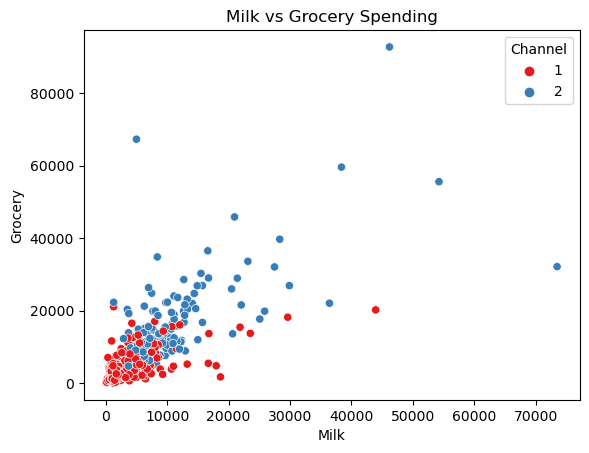

In [5]:
#Scatterplot
sns.scatterplot(df, x='Milk', y='Grocery', hue='Channel', palette='Set1')
plt.title('Milk vs Grocery Spending');

- From the plot above, we can see that Channel 1 customers spend less in milk and groceries than Channel 2. 
- We can also see that milk spending is proportional to the grocery budget.

**Histogram of MILK spending**

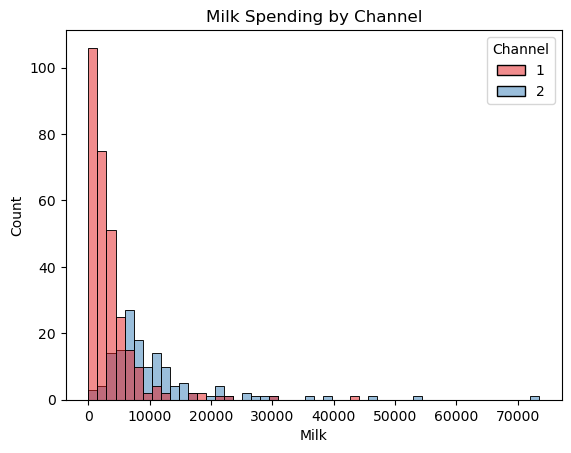

In [6]:
#Histogram
sns.histplot(df, x='Milk', hue='Channel', palette='Set1')
plt.title('Milk Spending by Channel');

**Annotated clustermap of the correlations between spending on different cateogires.**

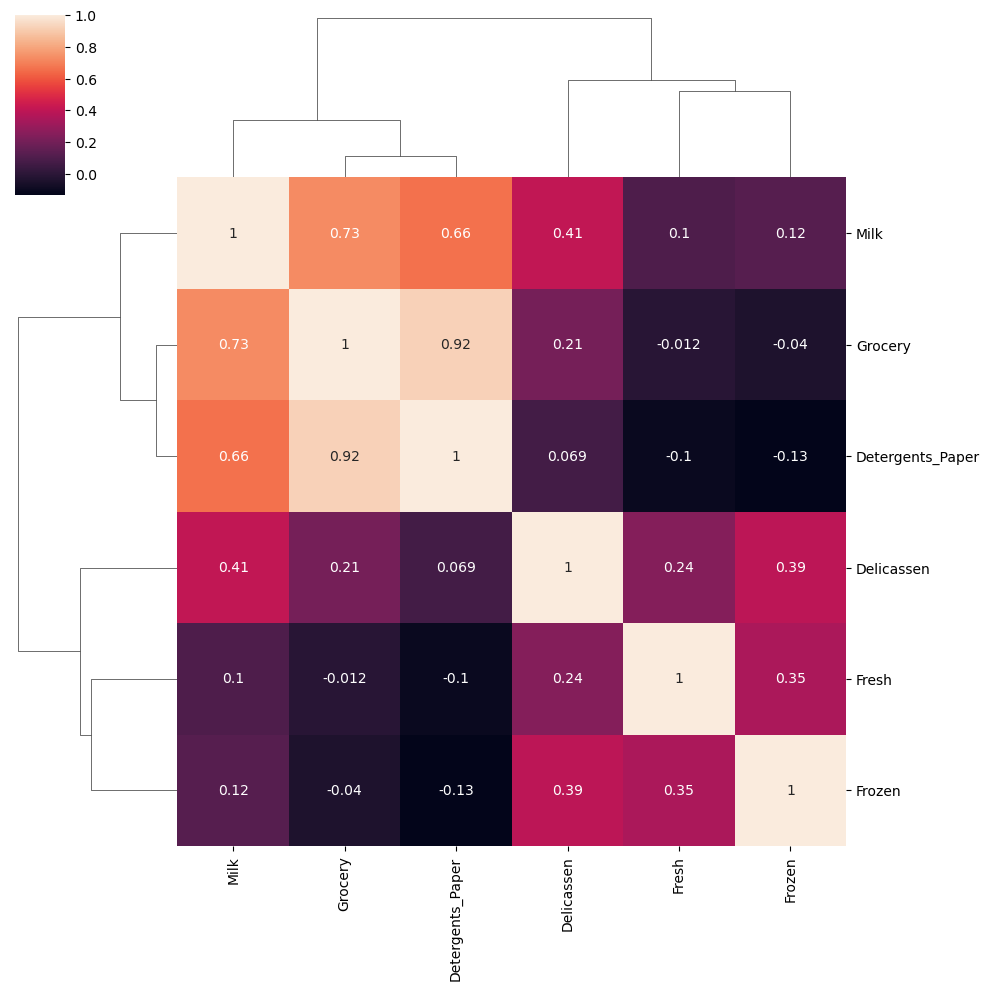

In [7]:
#clustermap
corr_df = df.drop(['Region', 'Channel'],axis=1).corr()
sns.clustermap(corr_df,annot=corr_df)

- Grocery and Detergents_Paper are very highly correlated (0.92)
- Grocery and Milk are very highly correlated (0.73)

**Clustermap colored by Region.**

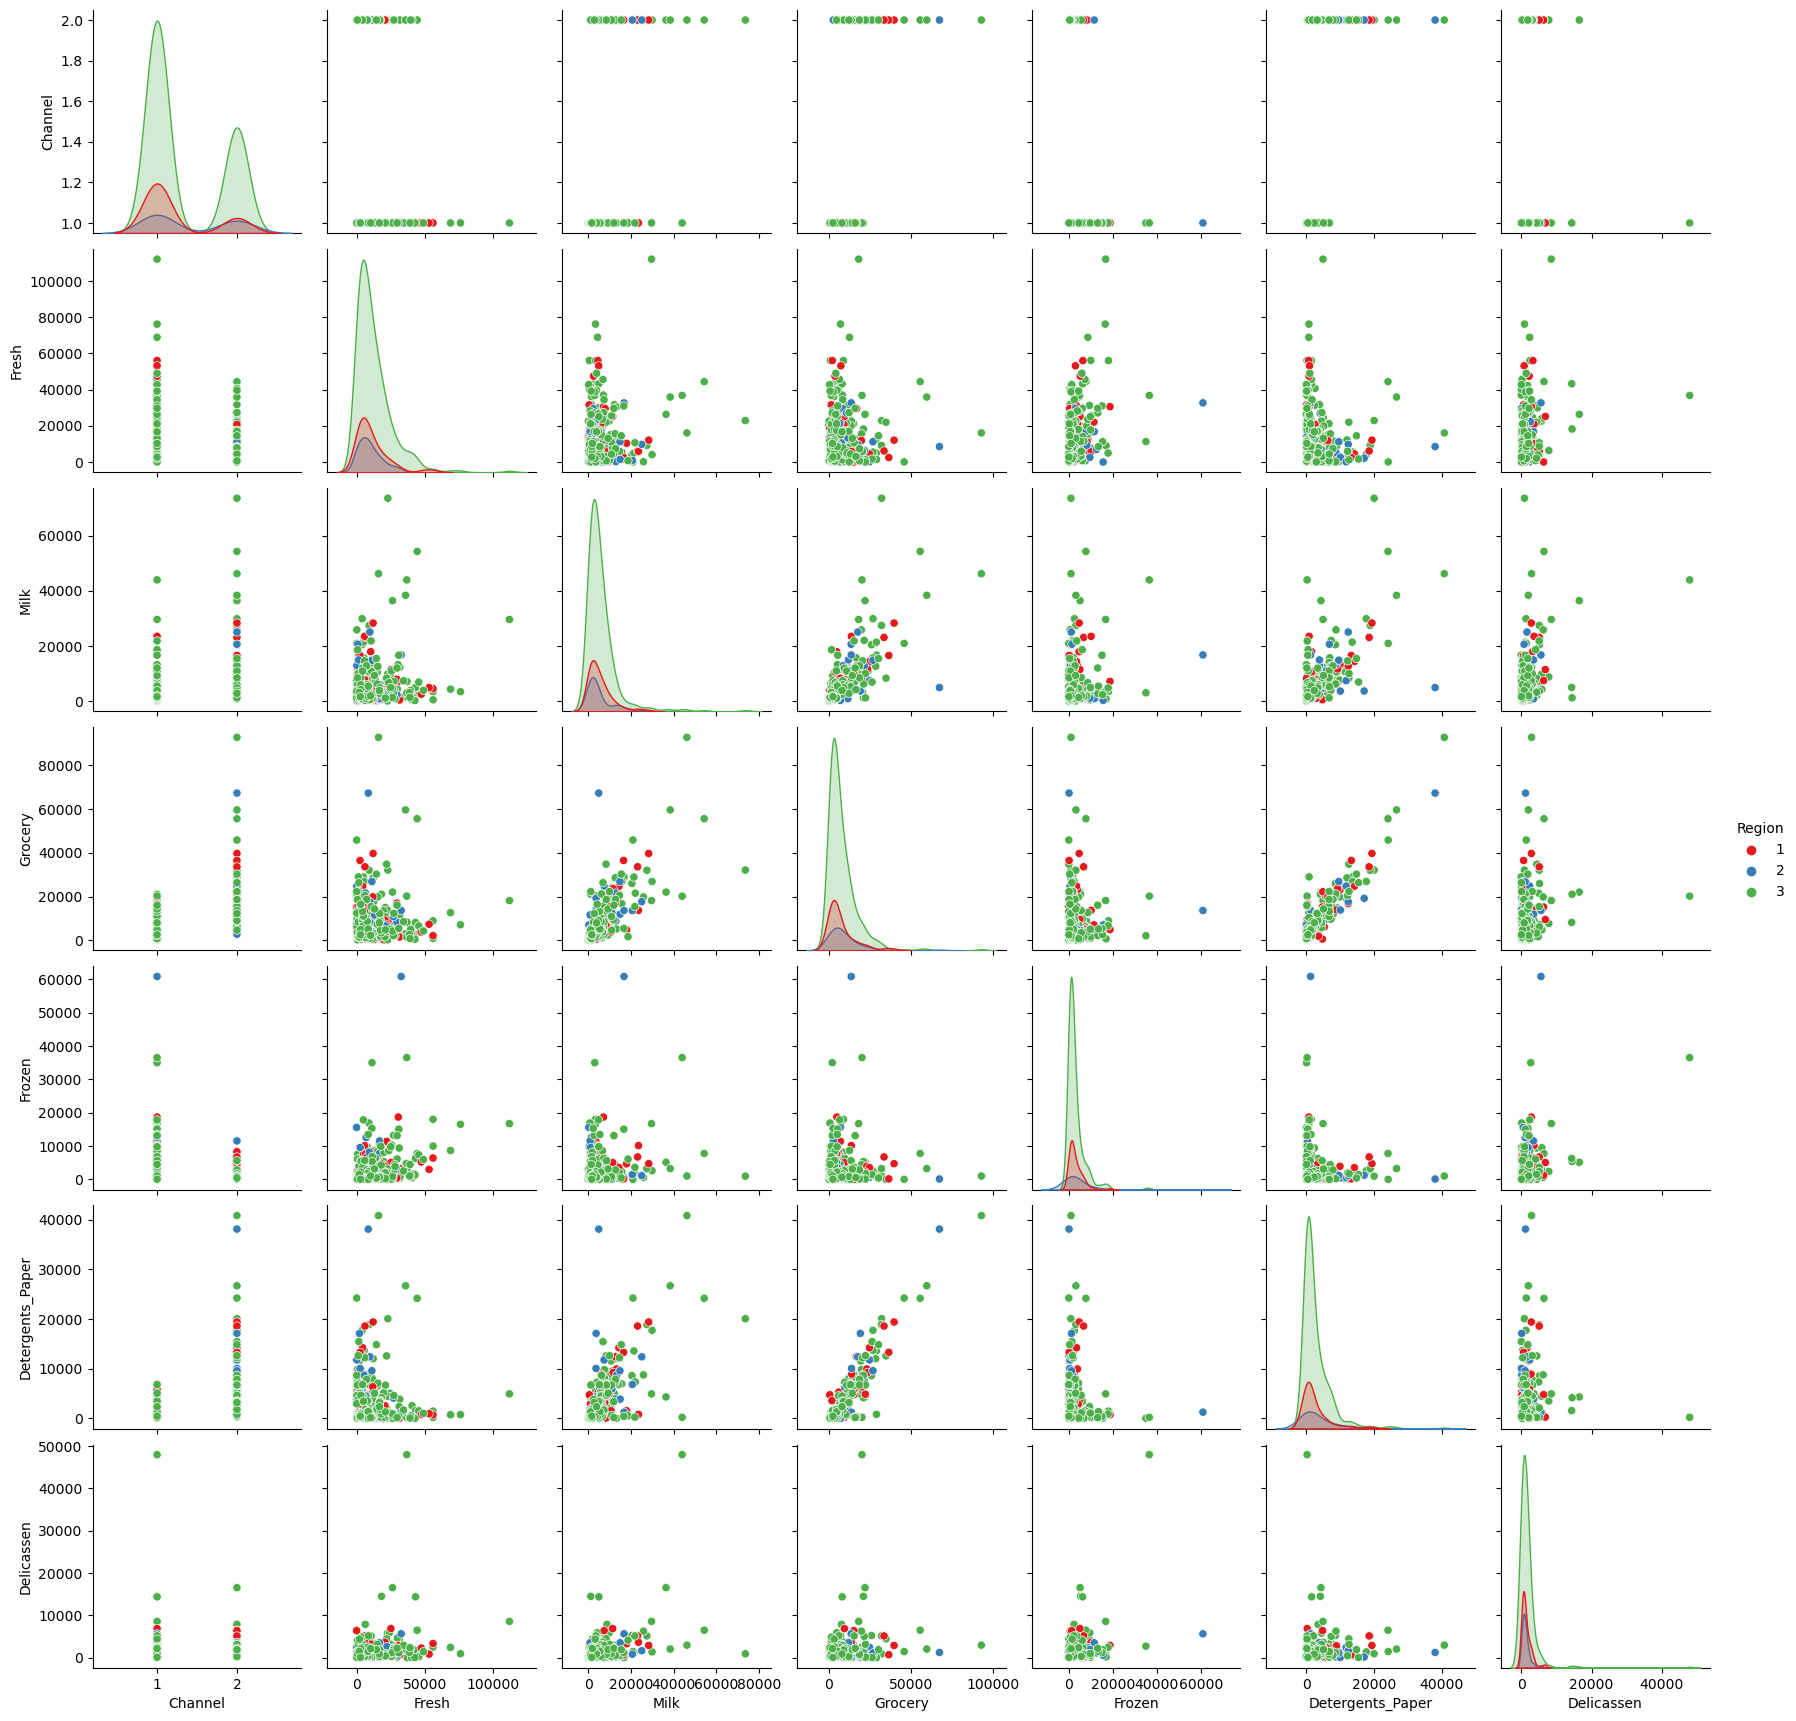

In [8]:
#clustermap
sns.pairplot(df, hue='Region', palette='Set1')

### Machine Learning


In [9]:
#Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_sc = sc.fit_transform(df)
df_sc

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

**For loop to create a variety of models testing different epsilon values. Tracking the percentage of points that are outliers.**


In [10]:
#for loop
from sklearn.cluster import DBSCAN

min_samples = df_sc.shape[1]*2
epsilon = np.linspace(0.001,3,50)
percentage_outliers = []

for e in epsilon:
    #fit model
    db_model = DBSCAN(eps=e, min_samples=min_samples)
    db_model.fit(df_sc)
    
    #calculate percentage of outliers
    perc_outliers = 100 * np.sum(db_model.labels_ == -1) / len(db_model.labels_)
    percentage_outliers.append(perc_outliers)
    

**Percentage of outlier points versus the epsilon value**

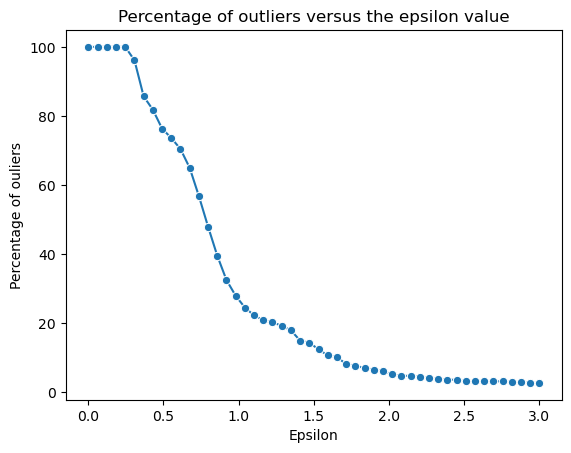

In [11]:
#lineplot
sns.lineplot(x=epsilon, y=percentage_outliers, marker='o')
plt.title('Percentage of outliers versus the epsilon value')
plt.xlabel('Epsilon')
plt.ylabel('Percentage of ouliers');

**DBSCAN with Epsilon=2**

In [12]:
db_model = DBSCAN(eps=2, min_samples=min_samples)
db_model.fit(df_sc)

DBSCAN(eps=2, min_samples=16)

**Milk vs Grocery, colored by Cluster.**

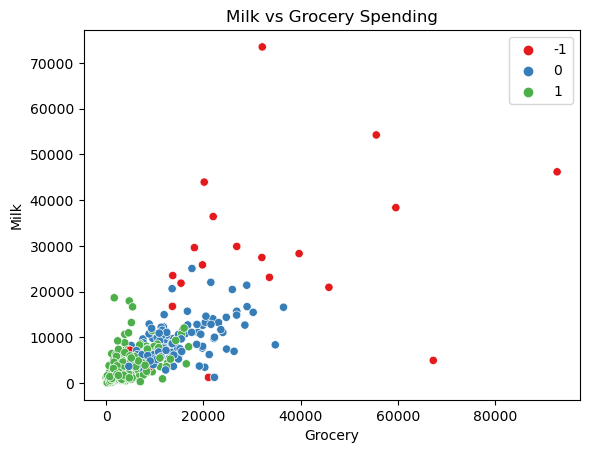

In [13]:
#scatterplot
sns.scatterplot(df, x='Grocery', y='Milk', hue=db_model.labels_, palette='Set1')
plt.title('Milk vs Grocery Spending');

- The plot above shows outliers in red.
- Cluster 1 spends less in Milk and Groceries than Cluster 2.

**Milk vs. Detergents Paper colored by Cluster.**

Text(0.5, 1.0, 'Milk vs. Detergents_Paper Spending')

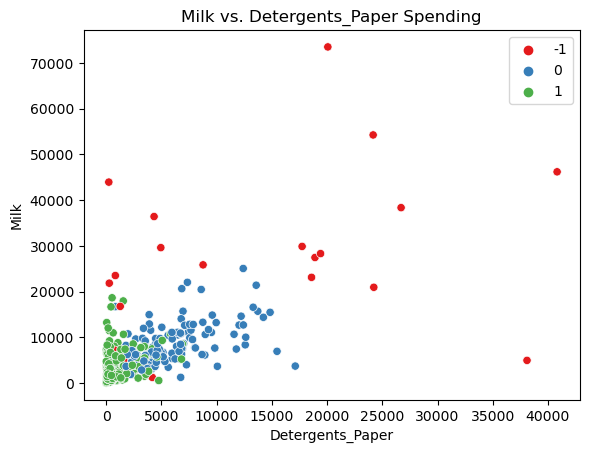

In [14]:
#scatterplot
sns.scatterplot(df, x='Detergents_Paper', y='Milk', hue=db_model.labels_, palette='Set1')
plt.title('Milk vs. Detergents_Paper Spending')

**Calculating mean expenditures per category for each cluster.**

In [15]:
#Add cluster number to df
df['Labels'] = db_model.labels_
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


In [16]:
# calculate mean
df_mean = df.groupby('Labels')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]\
                    .agg(['mean'])
df_mean.columns = df_mean.columns.droplevel(1)
df_mean

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,27729.920000,22966.960000,26609.600000,11289.640000,11173.560000,6707.160000
0,8227.666667,8615.852713,13859.674419,1447.759690,5969.581395,1498.457364
1,12326.972028,3023.559441,3655.328671,3086.181818,763.783217,1083.786713


<AxesSubplot:ylabel='Labels'>

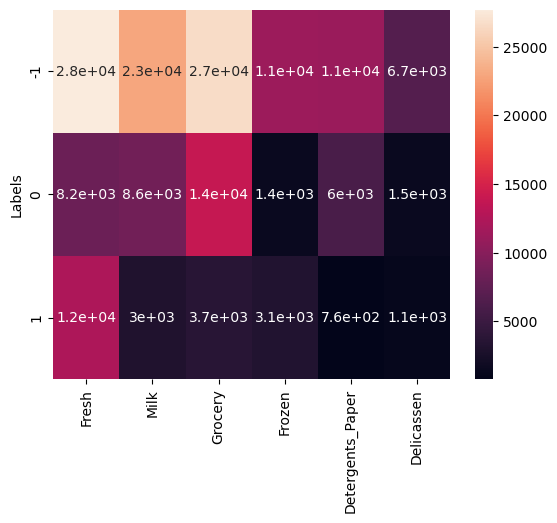

In [17]:
# Create heatmap
sns.heatmap(df_mean,annot=True)

- We can see that outliers in the data came from spending in Fresh, Milk, and Grocery categories.

**Using MinMaxScaler to normalize the spending mean.**

In [18]:
#MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
sc_min_max = MinMaxScaler()
df_mean_sc = pd.DataFrame(sc_min_max.fit_transform(df_mean),columns=df_mean.columns, index=df_mean.index)
df_mean_sc

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Labels,,,,,,
-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,0.000000,0.280408,0.444551,0.000000,0.500087,0.073741
1,0.210196,0.000000,0.000000,0.166475,0.000000,0.000000


<AxesSubplot:ylabel='Labels'>

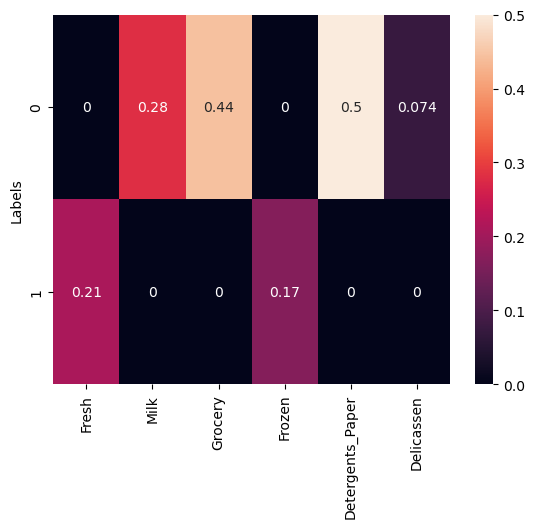

In [19]:
#Heatmap
sns.heatmap(df_mean_sc.iloc[1:,:],annot=True)

- Cluster 0 and Cluster 1 were most different in the Detergents_Paper, Groceries, and Milk categories, where Cluster 0 customers spend more money.
- Cluster 1 customers spent more money on Fresh and frozen foods.
- This analysis can target the customers in specific clusters with coupons and advertising that are more appealing to them. For example, customers in Cluster 1 can receive coupons for frozen foods, while Cluster 0 customers can receive coupons for detergent products.